In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('./../src/')
from manuscript import inout, export

In [2]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '01_assembling_data'    # name of notebook

In [3]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [4]:
p = os.path.join(
    inout.get_path_from_settings('materials_path'),
    'general/00_pull_data_from_edw/00patient-days.csv.gz'
)


# Prepare data

Goal here is to prepare data from the iteration 3 snapshot

# 1. Load the SOFA scores table

In [5]:
pt_days = pd.read_csv(p, index_col=0)

In [6]:
pt_days.shape

(13391, 42)

In [7]:
print(f"Number of patients: {pt_days.pt_study_id.nunique()}")
print(f"Number of ICU-days: {pt_days.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


In [8]:
pt_days.SOFA.isna().sum() #scores with NAs end up with sum NA now - will fix this below

5575

# 2. Merge endpoints table

In [9]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/basic_endpoints.csv.gz'
)

In [10]:
endpoints = pd.read_csv(p, encoding="unicode_escape")

In [11]:
endpoints_cols = """
pt_study_id
patient_ir_id
death_date
discharge_disposition_name
discharge_datetime
external_transfer_flag
admission_source_name
First_intub_start
First_intub_stop
Second_intub_start
Second_intub_stop
Third_intub_start
Third_intub_stop
Fourth_intub_start
Fourth_intub_stop
Fifth_intub_start
Fifth_intub_stop
first_recorded_ecmo
last_recorded_ecmo
""".strip().split("\n")

In [12]:
endpoints = endpoints[endpoints_cols]

In [13]:
data = pt_days.merge(endpoints[endpoints_cols], on="pt_study_id", how="left")

In [14]:
data.discharge_disposition_name.isna().sum()

0

In [15]:
data = data.loc[~data.discharge_disposition_name.isna(), :]

In [16]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


In [17]:
interesting_date_fields = """
day_bucket_starts
day_bucket_ends
icu_start_dt
icu_stop_dt
First_intub_start
First_intub_stop
Second_intub_start
Second_intub_stop
Third_intub_start
Third_intub_stop
Fourth_intub_start
Fourth_intub_stop
Fifth_intub_start
Fifth_intub_stop
first_recorded_ecmo
last_recorded_ecmo
""".strip().split("\n")

In [18]:
data[interesting_date_fields] = data[interesting_date_fields].apply(pd.to_datetime)

## 2.1 Rename and simplify discharge disposition

In [19]:
renames = {
    "Home with Home Health Care": "Home", 
    "Home or Self Care": "Home",
    "Against Medical Advice (AMA) or Elopement": "Home", 
    "Group Home": "Home", 
    "Home with Equipment or O2": "Home", 
    "Home with Outpatient Services": "Home", 
    "Inpatient Psychiatric Hospital": "Home",
        
    "Acute Inpatient Rehab": "Rehab",
    "Planned Readmission  DC/transferred to acute inpatient rehab": "Rehab",
    "Acute Inpatient Rehabilitation": "Rehab",
    
    "Skilled Nursing Facility or Subacute Rehab Care":"SNF",
    
    "Acute Care Hospital": "LTACH", 
    "Long-Term Acute Care Hospital (LTAC)": "LTACH", 
     
    "Home with Hospice": "Hospice", 
    "Inpatient Hospice": "Hospice", 

    "Expired": "Died"
}

In [20]:
data.discharge_disposition_name.replace(renames, inplace=True)

In [21]:
data["binary_outcome"] = "Alive"
data.loc[data.discharge_disposition_name.isin(["Hospice", "Died"]), "binary_outcome"] = "Died"

## 2.2 Set ECMO flag for each day

In [22]:
(~data.first_recorded_ecmo.isna()).sum()

3752

In [23]:
(data.first_recorded_ecmo.isna() & (~data.last_recorded_ecmo.isna())).sum()

0

In [24]:
((~data.first_recorded_ecmo.isna()) & data.last_recorded_ecmo.isna()).sum()

0

In [25]:
data.loc[:, "on_ecmo"] = (
    ((data.day_bucket_starts > data.first_recorded_ecmo) & (data.day_bucket_starts < data.last_recorded_ecmo))
    | ((data.day_bucket_ends > data.first_recorded_ecmo) & (data.day_bucket_ends < data.last_recorded_ecmo))
    | ((data.day_bucket_starts <= data.first_recorded_ecmo) & (data.day_bucket_ends >= data.last_recorded_ecmo))
)

In [26]:
data.on_ecmo.value_counts()

False    10545
True      2846
Name: on_ecmo, dtype: int64

This agrees with previous number

## 2.3 Set `intub` flag from intubation periods

As [pointed out](https://github.com/NUSCRIPT/script_etl_eda/issues/174#issuecomment-990303938) by Felix and Anna, `intub_flag` from SOFA scores table does not mean “is a person on intubation that day?”.

So let's compute our own field with this meaning

In [27]:
intub_order = ["First", "Second", "Third", "Fourth", "Fifth"]

In [28]:
bad_row = pd.Series(False, index=data.index)

In [29]:
for order in intub_order:
    bad_row |= (data[f"{order}_intub_start"].isna() & ~data[f"{order}_intub_stop"].isna())
    bad_row |= (data[f"{order}_intub_stop"].isna() & ~data[f"{order}_intub_start"].isna())

In [30]:
data.loc[bad_row, "pt_study_id"].value_counts()

Series([], Name: pt_study_id, dtype: int64)

In [31]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


In [32]:
on_intub = pd.Series(False, index=data.index)

In [33]:
for order in intub_order:
    on_intub |= ((data.day_bucket_starts > data[f"{order}_intub_start"]) 
                 & (data.day_bucket_starts < data[f"{order}_intub_stop"]))
    on_intub |= ((data.day_bucket_ends > data[f"{order}_intub_start"]) 
                 & (data.day_bucket_ends < data[f"{order}_intub_stop"]))
    on_intub |= ((data.day_bucket_starts <= data[f"{order}_intub_start"])
                 & (data.day_bucket_ends >= data[f"{order}_intub_stop"]))

In [34]:
on_intub.value_counts()

True     11187
False     2204
dtype: int64

In [35]:
data["on_intub"] = on_intub

# 3. Merge ventilator parametes

In [36]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/SCRIPT ventilator settings V2.0 3-31-22.csv.gz'
)

In [37]:
vent_params = pd.read_csv(p)

In [38]:
vent_params.shape

(53568, 12)

In [39]:
vent_params["date"] = pd.to_datetime(pd.to_datetime(vent_params.meas_date).dt.date)

In [40]:
params_of_interest = ["Peep", "Plateau_Pressure", "Static_Compliance", "FiO2"]

In [41]:
vents = vent_params

## 3.1 Curate values

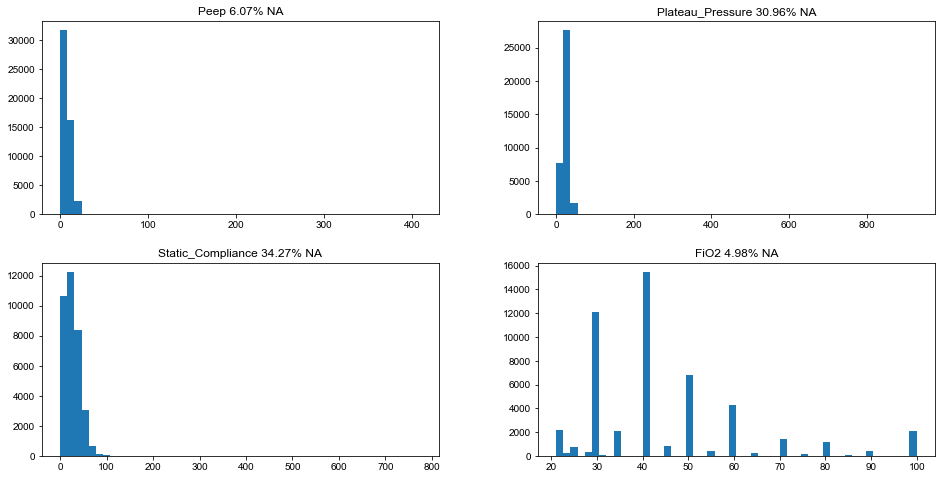

In [42]:
columns = np.array(params_of_interest)
cols = columns.reshape(2, 2)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 8), 
    gridspec_kw={"wspace": 0.25, "hspace": 0.25}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        if isinstance(column, str) and column in vents:
            ax.hist(
                vents[column], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {vents[column].isna().sum() * 100 / vents.shape[0]:.2f}% NA")

In [43]:
allowed_range = {
    "Peep": (0, 26),
    "Plateau_Pressure": (5, 55),
    "Static_Compliance": (0, 100),
    "FiO2": (0, 100)
}

In [44]:
for column in params_of_interest:
    for c, ranges in allowed_range.items():
        if column == c:
            break
        if c in column:
            break
    if c != column and c not in column:
        continue
    n_val = ((vents[column] < ranges[0]) | (vents[column] > ranges[1])).sum()
    vents.loc[(vents[column] < ranges[0]) | (vents[column] > ranges[1]), column] = np.nan
    print(f"# of values outside of range {ranges} for {column} = {n_val}")

# of values outside of range (0, 26) for Peep = 31
# of values outside of range (5, 55) for Plateau_Pressure = 48
# of values outside of range (0, 100) for Static_Compliance = 47
# of values outside of range (0, 100) for FiO2 = 0


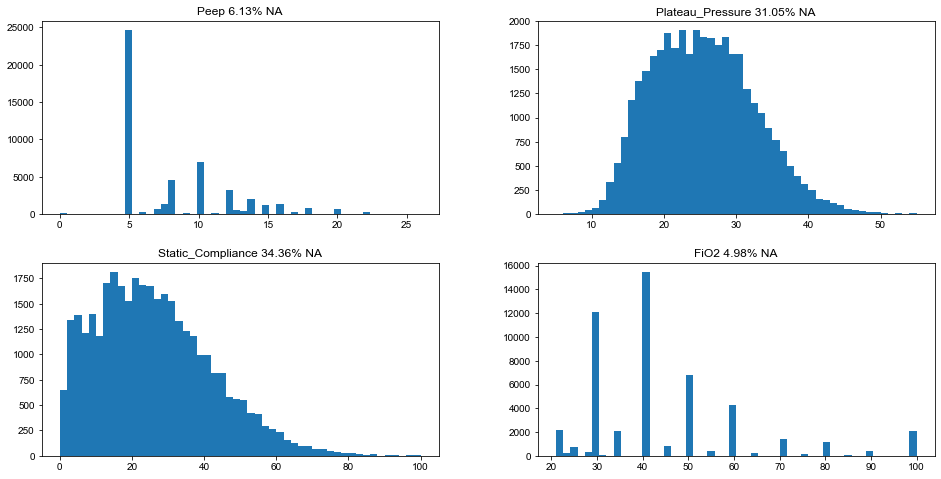

In [45]:
columns = np.array(params_of_interest)
cols = columns.reshape(2, 2)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 8), 
    gridspec_kw={"wspace": 0.25, "hspace": 0.25}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        if isinstance(column, str) and column in vents:
            ax.hist(
                vents[column], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {vents[column].isna().sum() * 100 / vents.shape[0]:.2f}% NA")

## 3.2 Aggregate per day

Let's compute how much parameters change per day

In [46]:
vents.groupby(["ir_id", "date"]).apply(lambda x: x[["Peep", "Set_Rate"]].diff().ne(0).sum()).value_counts()

Peep  Set_Rate
1     1           5601
      2           1168
2     1           1058
1     3            898
2     2            788
3     3            548
1     4            501
3     1            321
4     4            296
2     3            275
3     2            216
1     5            189
3     4            160
2     4            128
5     5             91
4     3             84
3     5             79
1     6             63
2     5             44
4     1             43
      2             40
6     6             28
3     6             24
4     5             23
5     3             18
      1             18
      6             16
      4             15
1     7             10
3     7             10
6     5              8
2     6              8
7     7              5
6     4              5
5     2              5
4     6              5
      7              4
5     7              4
7     6              3
2     7              3
8     8              3
6     3              3
7     8            

In [47]:
agg_vents = vents.loc[:, ["ir_id", "date"] + params_of_interest].groupby(["ir_id", "date"]).mean()

In [48]:
vents_changes = vents.groupby(["ir_id", "date"]).apply(
    lambda x: x[["Peep", "Set_Rate", "FiO2"]].diff().ne(0).sum()
).rename({"Peep": "n_peep_changes", "Set_Rate": "n_set_rate_changes", "FiO2": "n_fio2_changes"}, axis=1)

In [49]:
agg_vents = agg_vents.merge(
    vents_changes,
    left_index=True,
    right_index=True
).reset_index()

In [50]:
merged = data.merge(
    agg_vents,
    left_on=["patient_ir_id", "day_bucket_starts"],
    right_on=["ir_id", "date"],
    how="left"
)

In [51]:
data = merged

Check correspondence between presence of `Peep` and `on_intub` flag

In [52]:
data.groupby([~data.Peep.isna(), 'on_intub']).size()

Peep   on_intub
False  False        2191
       True          302
True   False          13
       True        10885
dtype: int64

# 4. Merge labs

In [53]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/SCRIPT Patients Labs3-31-22.csv.gz'
)

In [54]:
labs = pd.read_csv(p)

In [55]:
labs.component_name.value_counts()

CREATININE                62573
Bicarbonate               61263
PLATELET COUNT            54183
HEMOGLOBIN                54138
WHITE BLOOD CELL COUNT    51601
ALBUMIN                   31861
TOTAL BILIRUBIN           29954
ABSOLUTE LYMPHOCYTES      29813
ABSOLUTE NEUTROPHILS      29617
Lactic Acid               18690
LDH                       13560
D-DIMER                    7380
PROCALCITONIN              5768
C-REACTIVE PROTEIN         5348
FERRITIN                   4100
Name: component_name, dtype: int64

Dropping as we already have them

In [56]:
labs = labs.loc[~labs.component_name.isin(["CREATININE", "PLATELET COUNT", "TOTAL BILIRUBIN"]), :].copy()

## 4.1 Curate values

In [57]:
non_number_idx = ~labs.value.str.match("^\d+(\.\d+)?$")

In [58]:
labs.value[non_number_idx].nunique()

32

In [59]:
labs.value[non_number_idx].value_counts()

WBC too low to do differential. Smear on file.    1172
<0.1                                               520
<0.5                                               277
See Comment                                        243
<0.05                                              147
<150                                               138
<0.050                                             132
>45                                                 43
<1.0                                                38
<1.5                                                37
>15000.0                                            23
SEE COMMENT                                         19
>69000                                              16
>1500.0                                             14
<230                                                13
Not Measured                                         8
>15000                                               6
>12000                                               4
Not Report

In [60]:
labs.value = labs.value.str.replace("^(>|<)", "", regex=True)

In [61]:
non_number_idx = ~labs.value.str.match("^\d+(\.\d+)?$")

In [62]:
labs.value[non_number_idx].value_counts()

WBC too low to do differential. Smear on file.    1172
See Comment                                        243
SEE COMMENT                                         19
Not Measured                                         8
Not Reported                                         4
In Error                                             2
See comment                                          2
see comment                                          2
FAILED                                               1
in error                                             1
clotted                                              1
Name: value, dtype: int64

In [63]:
labs.loc[labs.value == "WBC too low to do differential. Smear on file.", "value"] = "0"

In [64]:
non_number_idx = ~labs.value.str.match("^\d+(\.\d+)?$")

In [65]:
labs.value[non_number_idx].value_counts()

See Comment     243
SEE COMMENT      19
Not Measured      8
Not Reported      4
In Error          2
See comment       2
see comment       2
FAILED            1
in error          1
clotted           1
Name: value, dtype: int64

In [66]:
labs = labs.loc[~non_number_idx, :].copy()

In [67]:
labs.value = labs.value.astype(float)

## 4.2 Curate units

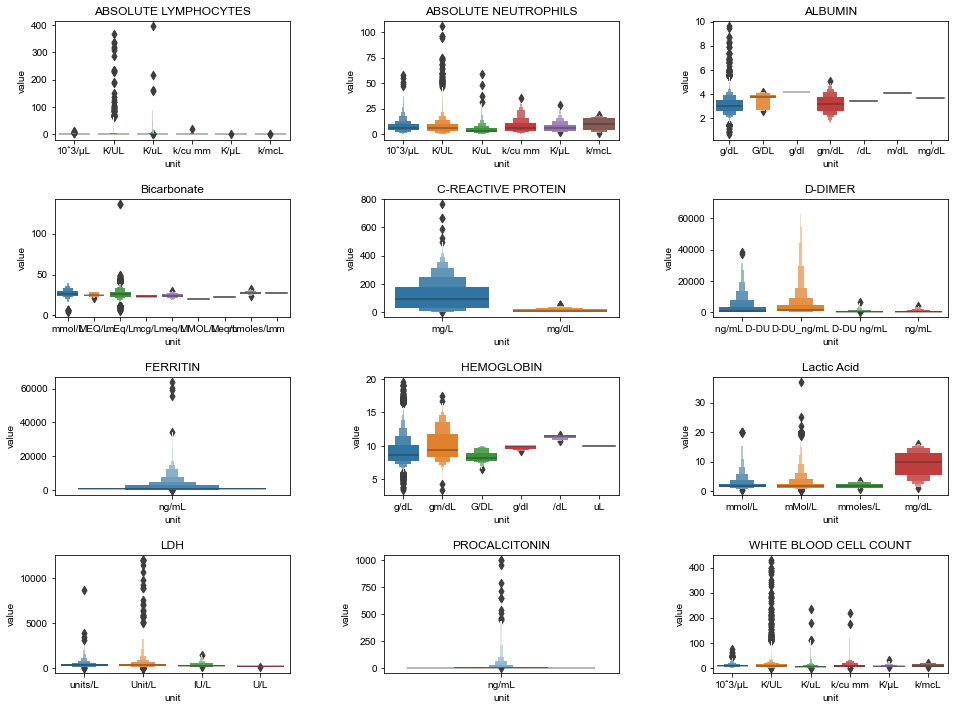

In [68]:
columns = labs.component_name.unique().reshape(4, 3)
fig, axes = plt.subplots(
    nrows=columns.shape[0], 
    ncols=columns.shape[1], 
    figsize=(16, 12), 
    gridspec_kw={"wspace": 0.4, "hspace": 0.5}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        meas = columns[row, col]
        ax = axes[row, col]
        sns.boxenplot(
            data=labs.loc[labs.component_name == meas],
            y="value",
            x="unit",
            ax=ax,
            k_depth="proportion"
        )
        for a in ax.collections:
            if isinstance(a, mpl.collections.PatchCollection):
                # remove line surround each box
                a.set_linewidth(0)
        ax.set_title(meas)

All values are compatible except:
1. CRP: need to multiple `mg/dL` values by 10
2. Lactic Acid: need to drop `mg/dL` values

In [69]:
labs.loc[(labs.component_name == "C-REACTIVE PROTEIN") & (labs.unit == "mg/dL"), "value"] *= 10

In [70]:
labs = labs.loc[~((labs.component_name == "Lactic Acid") & (labs.unit == "mg/dL")), :].copy()

## 4.3 Curate ranges

Rename values

In [71]:
lab_names = {
    'ABSOLUTE LYMPHOCYTES': "Lymphocytes", 
    'ABSOLUTE NEUTROPHILS': "Neutrophils", 
    'ALBUMIN': "Albumin",
    'C-REACTIVE PROTEIN': "CRP", 
    'D-DIMER': "D-dimer", 
    'FERRITIN': "Ferritin",
    'HEMOGLOBIN': "Hemoglobin", 
    'PROCALCITONIN': "Procalcitonin",
    'WHITE BLOOD CELL COUNT': "WBC count"
}

In [72]:
labs.component_name.replace(lab_names, inplace=True)

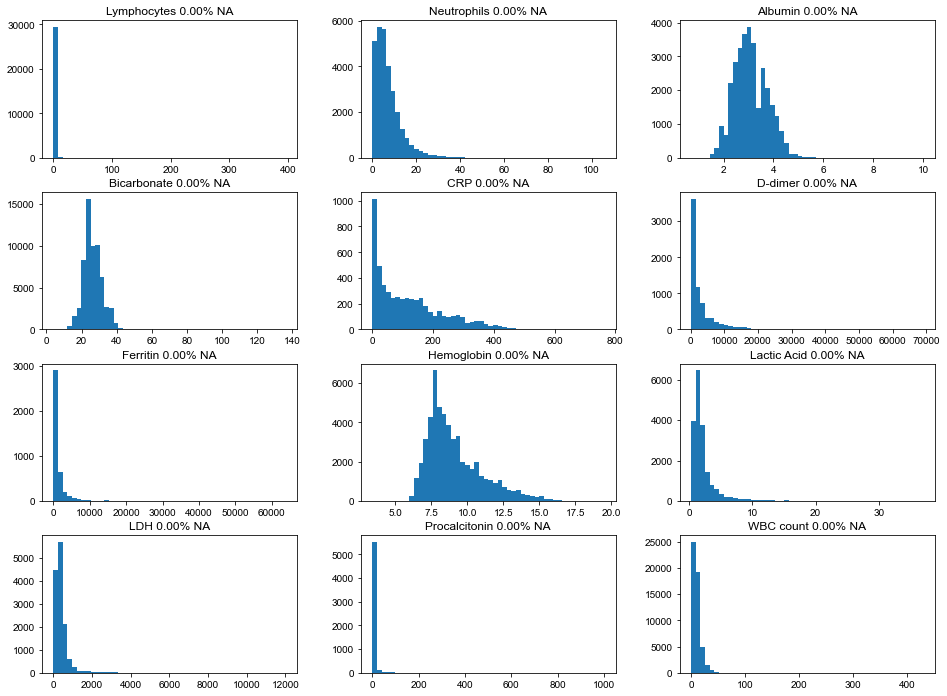

In [73]:
columns = np.array(labs.component_name.unique())
cols = columns.reshape(4, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 12), 
    gridspec_kw={"wspace": 0.25, "hspace": 0.25}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        idx = labs.component_name.eq(column)
        if isinstance(column, str):
            ax.hist(
                labs.value[idx], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {labs.value[idx].isna().sum() * 100  / idx.sum():.2f}% NA")

In [74]:
allowed_range = {
    "Albumin": (0, 6),
    "Bicarbonate": (0, 45),
    "CRP": (0, 500),
    "D-dimer": (0, 40000),
    "Ferritin": (0, 10000),
    "Hemoglobin": (5, 15),
    "LDH": (0, 2000),
    "Lactic Acid": (0, 7),
    "Lymphocytes": (0, 6),
    "Neutrophils": (0, 50),
    "Procalcitonin": (0, 50),
    "WBC count": (0, 70),
}

In [75]:
for column in labs.component_name.unique():
    for c, ranges in allowed_range.items():
        if column == c:
            break
        if c in column:
            break
    if c != column and c not in column:
        continue
    idx = labs.component_name.eq(column)
    n_val = ((labs.value[idx] < ranges[0]) | (labs.value[idx] > ranges[1])).sum()
    labs.loc[idx & ((labs.value < ranges[0]) | (labs.value > ranges[1])), "value"] = np.nan
    print(f"# of values outside of range {ranges} for {column} = {n_val}")

# of values outside of range (0, 6) for Lymphocytes = 336
# of values outside of range (0, 50) for Neutrophils = 41
# of values outside of range (0, 6) for Albumin = 27
# of values outside of range (0, 45) for Bicarbonate = 11
# of values outside of range (0, 500) for CRP = 7
# of values outside of range (0, 40000) for D-dimer = 128
# of values outside of range (0, 10000) for Ferritin = 87
# of values outside of range (5, 15) for Hemoglobin = 591
# of values outside of range (0, 7) for Lactic Acid = 910
# of values outside of range (0, 2000) for LDH = 222
# of values outside of range (0, 50) for Procalcitonin = 105
# of values outside of range (0, 70) for WBC count = 148


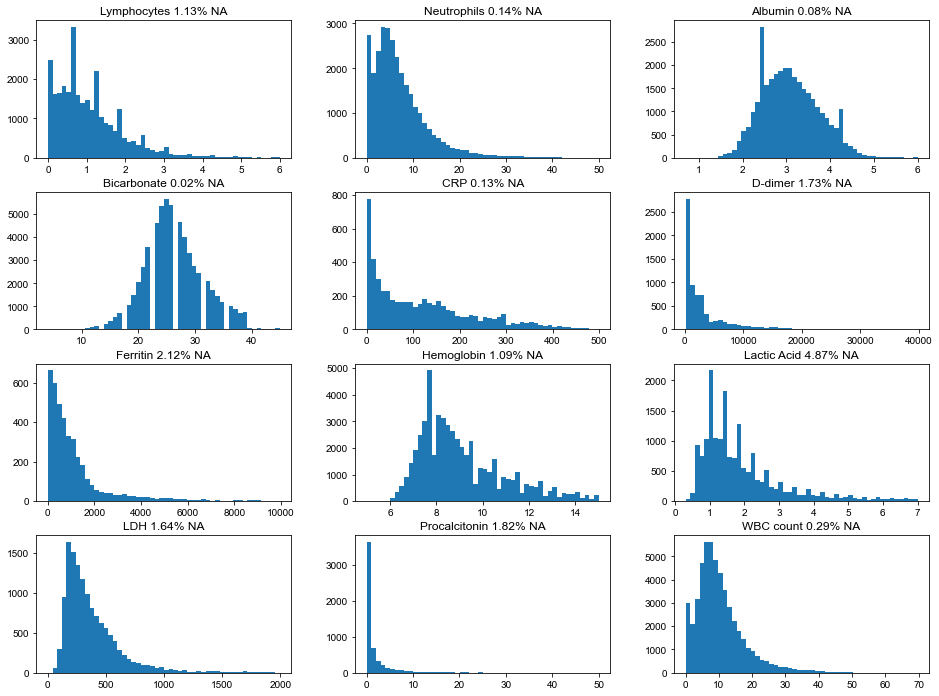

In [76]:
columns = np.array(labs.component_name.unique())
cols = columns.reshape(4, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 12), 
    gridspec_kw={"wspace": 0.25, "hspace": 0.25}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        idx = labs.component_name.eq(column)
        if isinstance(column, str):
            ax.hist(
                labs.value[idx], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {labs.value[idx].isna().sum() * 100  / idx.sum():.2f}% NA")

## 4.4 Aggregate by date

In [77]:
labs["date"] = pd.to_datetime(labs.order_datetime).dt.date

In [78]:
labs.date = pd.to_datetime(labs.date)

In [79]:
value_per_day = labs.groupby(["pt_study_id", "date", "component_name"]).count().value

In [80]:
value_per_day.reset_index().groupby("component_name").agg({"value": "mean"})

,value
component_name,
Albumin,1.116595
Bicarbonate,1.506123
CRP,1.015592
D-dimer,1.118464
Ferritin,0.995288
Hemoglobin,1.332719
LDH,1.082718
Lactic Acid,2.117984
Lymphocytes,1.063372


In [81]:
agg_labs = labs.groupby(["pt_study_id", "component_name", "date"]).agg({"value": "mean"}).reset_index()

In [82]:
agg_labs = agg_labs.pivot_table(
    columns="component_name", 
    values="value", 
    index=["pt_study_id", "date"]
).reset_index()

In [83]:
merged = data.merge(
    agg_labs, 
    left_on=["pt_study_id", "day_bucket_starts"], 
    right_on=["pt_study_id", "date"],
    how="outer"
)

In [84]:
merged.icu_rank.isna().sum()

28798

In [85]:
merged.date_y.isna().sum()

129

In [86]:
merged = merged.loc[~merged.icu_rank.isna(), :]

In [87]:
data = merged

In [88]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


# 5. Merge vitals and arterial blood gas

Following Cathy's [notebook](https://github.com/NUSCRIPT/cereal/blob/master/01dataCAG3-21-22.ipynb), based on notebooks [here](https://github.com/NUSCRIPT/cereal/blob/master/add_vitals.ipynb) and [here](https://github.com/NUSCRIPT/cereal/blob/master/z03-omop_abg-12-12-21.ipynb)

Vitals of interest

In [89]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/vitals.csv.gz"'
)

In [90]:
vital_cols = [
    'Diastolic blood pressure', 
    'Systolic blood pressure', 
    'Body temperature', 
    'Respiratory rate', 
    'Heart rate', 
    'Oxygen saturation in Arterial blood by Pulse oximetry',
    'pH of Arterial blood', 
    'Carbon dioxide [Partial pressure] in Arterial blood',  
    'Oxygen [Partial pressure] in Arterial blood',
    'Bicarbonate [Moles/volume] in Arterial blood' 
]

In [91]:
p2 = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/measurement.csv.gz'
)

In [92]:
cache = p
if os.path.exists(cache):
    vitals = pd.read_csv(cache)
else:
    vitals = pd.read_csv(p2, encoding="unicode_escape")
    vitals = vitals.loc[vitals.measurement_concept_name.isin(vital_cols), :]
    vitals.to_csv(cache)

/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (17,18,19,20,44,45,48,49,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 5.1 Curate units

In [93]:
vitals.unit_concept_name.fillna("NA", inplace=True)

In [94]:
vitals.groupby("measurement_concept_name").unit_concept_name.value_counts()

measurement_concept_name                               unit_concept_name        
Bicarbonate [Moles/volume] in Arterial blood           millimole per liter           35742
                                                       NA                              657
Body temperature                                       degree Fahrenheit            374436
                                                       degree Celsius                21744
Carbon dioxide [Partial pressure] in Arterial blood    millimeter mercury column     37060
                                                       NA                              660
Diastolic blood pressure                               millimeter mercury column    692662
Heart rate                                             counts per minute            676022
Oxygen [Partial pressure] in Arterial blood            millimeter mercury column     37054
                                                       NA                              659
Oxygen sa

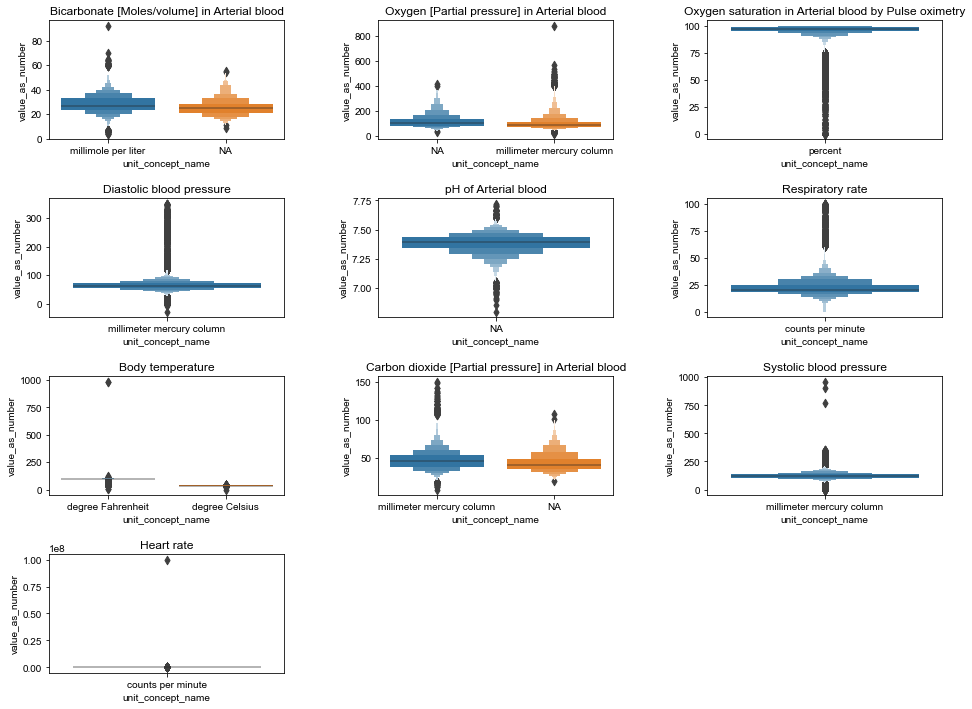

In [95]:
columns = np.array(vitals.measurement_concept_name.unique().tolist() + [None, None]).reshape(4, 3)
fig, axes = plt.subplots(
    nrows=columns.shape[0], 
    ncols=columns.shape[1], 
    figsize=(16, 12), 
    gridspec_kw={"wspace": 0.4, "hspace": 0.5}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        meas = columns[row, col]
        ax = axes[row, col]
        if not meas:
            ax.remove()
            continue
        sns.boxenplot(
            data=vitals.loc[vitals.measurement_concept_name == meas],
            y="value_as_number",
            x="unit_concept_name",
            ax=ax,
            k_depth="proportion"
        )
        for a in ax.collections:
            if isinstance(a, mpl.collections.PatchCollection):
                # remove line surround each box
                a.set_linewidth(0)
        ax.set_title(meas)

Curate temperature

In [96]:
vitals.loc[
    (vitals.value_as_number > 800) & (vitals.unit_concept_name == 'degree Fahrenheit'), 
    'value_as_number'
] *= 0.1

In [97]:
vitals.loc[
    (vitals.value_as_number < 20) & (vitals.unit_concept_name=='degree Fahrenheit'), 
    'value_as_number'
] *= 10

In [98]:
f = (
    (vitals.measurement_concept_name == "Body temperature") 
    & (vitals.unit_concept_name == "degree Celsius")
)
vitals.loc[f, "value_as_number"] = vitals.loc[f, "value_as_number"] * 9 / 5 + 32

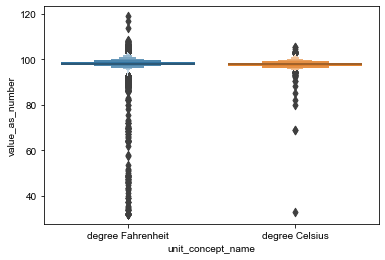

In [99]:
fig, ax = plt.subplots()
sns.boxenplot(
    data=vitals.loc[vitals.measurement_concept_name == "Body temperature"],
    y="value_as_number",
    x="unit_concept_name",
    ax=ax,
    k_depth="proportion"
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)

## 5.2 Curate values

In [100]:
vitals_names = {
    'Diastolic blood pressure': "dia_blood_press",
    'Systolic blood pressure': "sys_blood_press",
    'Body temperature': "body_temp",
    'Respiratory rate': "resp_rate",
    'Heart rate': "heart_rate",
    'Oxygen saturation in Arterial blood by Pulse oximetry': "oxigen_sat",
    'pH of Arterial blood': "abg_ph",
    'Carbon dioxide [Partial pressure] in Arterial blood': "abg_paco2",
    'Oxygen [Partial pressure] in Arterial blood': "abg_pao2",
    'Bicarbonate [Moles/volume] in Arterial blood': "abg_bicarb",
}

In [101]:
vitals.measurement_concept_name.replace(vitals_names, inplace=True)

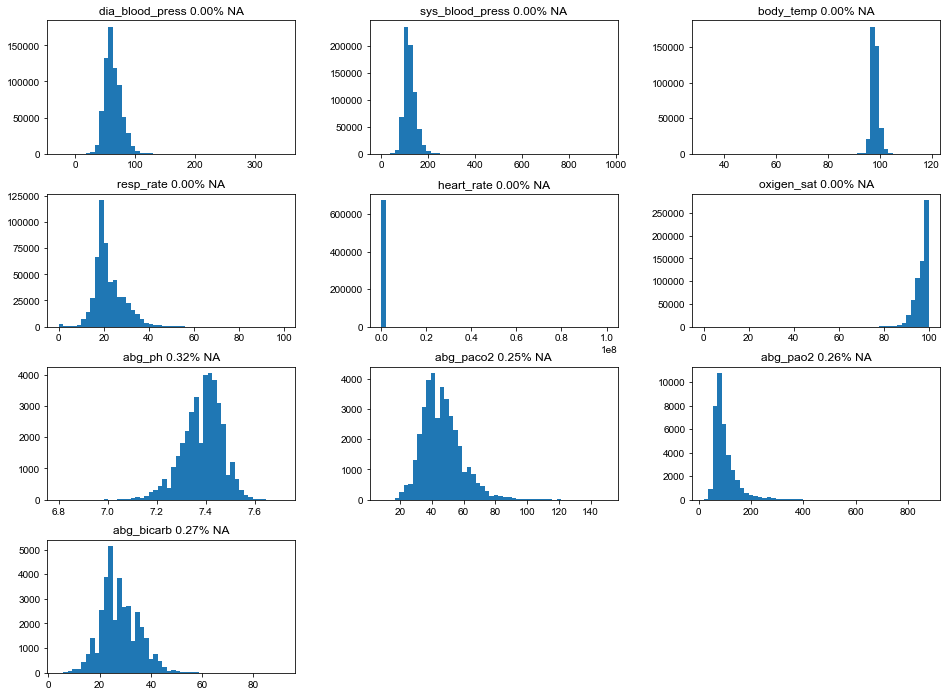

In [102]:
columns = np.array(list(vitals_names.values()))
cols = np.pad(columns, (0, 12 - columns.size), constant_values=np.nan).reshape(4, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 12), 
    gridspec_kw={"wspace": 0.3, "hspace": 0.3}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        if isinstance(column, str) and column != 'nan':
            idx = vitals.measurement_concept_name.eq(column)
            ax.hist(
                vitals.value_as_number[idx], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {vitals.value_as_number[idx].isna().sum() * 100 / idx.sum():.2f}% NA")
        else:
            ax.remove()

In [103]:
allowed_range = {
    "abg_paco2": (10, 120),
    "abg_pao2": (0, 500),
    "body_temp": (80, 110),
    "dia_blood_press": (20, 150),
    "heart_rate": (30, 200),
    "oxigen_sat": (50, 100),
    "resp_rate": (1, 75),
    "sys_blood_press": (30, 230)
}

In [104]:
for column in vitals.measurement_concept_name.unique():
    for c, ranges in allowed_range.items():
        if column == c:
            break
        if c in column:
            break
    if c != column and c not in column:
        continue
    idx = vitals.measurement_concept_name.eq(column)
    n_val = ((vitals.value_as_number[idx] < ranges[0]) | (vitals.value_as_number[idx] > ranges[1])).sum()
    vitals.loc[idx & ((vitals.value_as_number < ranges[0]) | (vitals.value_as_number > ranges[1])), "value_as_number"] = np.nan
    print(f"# of values outside of range {ranges} for {column} = {n_val}")

# of values outside of range (0, 500) for abg_pao2 = 5
# of values outside of range (50, 100) for oxigen_sat = 263
# of values outside of range (20, 150) for dia_blood_press = 777
# of values outside of range (1, 75) for resp_rate = 2857
# of values outside of range (80, 110) for body_temp = 115
# of values outside of range (10, 120) for abg_paco2 = 23
# of values outside of range (30, 230) for sys_blood_press = 745
# of values outside of range (30, 200) for heart_rate = 336


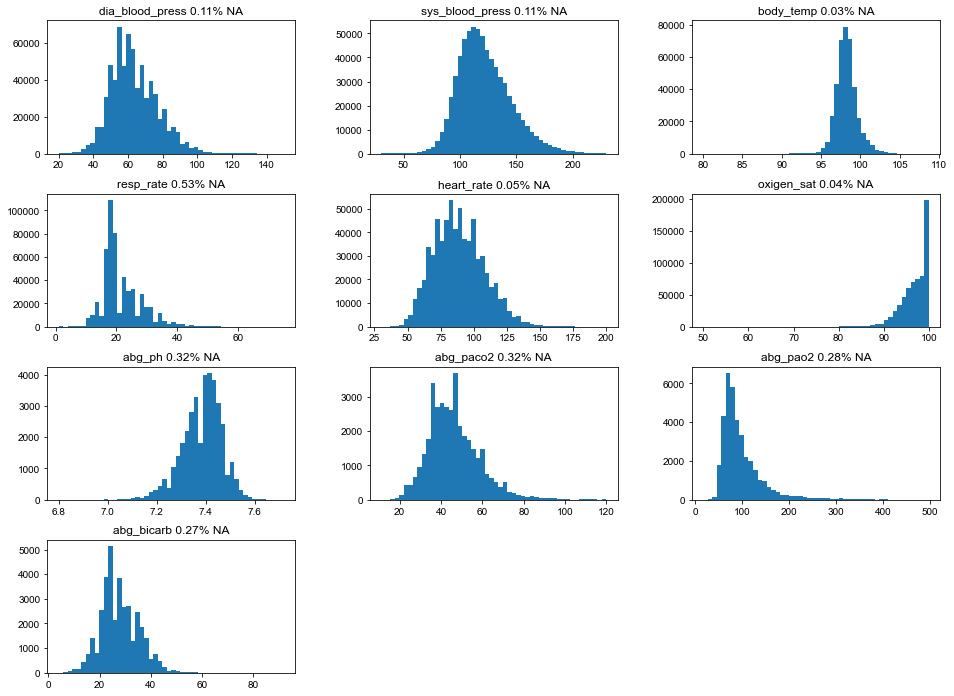

In [105]:
columns = np.array(list(vitals_names.values()))
cols = np.pad(columns, (0, 12 - columns.size), constant_values=np.nan).reshape(4, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 12), 
    gridspec_kw={"wspace": 0.3, "hspace": 0.3}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        if isinstance(column, str) and column != 'nan':
            idx = vitals.measurement_concept_name.eq(column)
            ax.hist(
                vitals.value_as_number[idx], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {vitals.value_as_number[idx].isna().sum() * 100 / idx.sum():.2f}% NA")
        else:
            ax.remove()

## 5.3 Aggregate

In [106]:
vitals.measurement_datetime = pd.to_datetime(vitals.measurement_datetime).dt.date

How many measurements per day?

In [107]:
value_per_day = vitals.groupby(
    ["person_id", "measurement_datetime", "measurement_concept_name"]
).count().value_as_number

In [108]:
value_per_day.reset_index().groupby("measurement_concept_name").agg({"value_as_number": "mean"})

,value_as_number
measurement_concept_name,
abg_bicarb,3.984305
abg_paco2,4.033576
abg_pao2,4.036167
abg_ph,4.034664
body_temp,7.504500
dia_blood_press,12.141742
heart_rate,11.885000
oxigen_sat,13.546699
resp_rate,10.530005


In [109]:
agg_vitals = vitals.groupby(
    ["person_id", "measurement_datetime", "measurement_concept_name"]
).agg({"value_as_number": ["mean"]})

In [110]:
agg_vitals = agg_vitals.pivot_table(
    columns="measurement_concept_name", 
    values="value_as_number", 
    index=["person_id", "measurement_datetime"]
).reset_index()

In [111]:
agg_vitals.measurement_datetime = pd.to_datetime(agg_vitals.measurement_datetime)

In [112]:
agg_vitals.columns = [" ".join(col).strip().replace(" ", "_") for col in agg_vitals.columns.values]

In [113]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/patient.csv.gz'
)

In [114]:
patients = pd.read_csv(p)

In [115]:
agg_vitals = agg_vitals.merge(patients, left_on="person_id", right_on="cohort_patient_id", how="left")

In [116]:
agg_vitals.case_number.isna().sum()

0

In [117]:
merged = data.merge(
    agg_vitals, 
    left_on=["pt_study_id", "day_bucket_starts"], 
    right_on=["case_number", "measurement_datetime"],
    how="left"
)

In [118]:
merged.case_number.isna().sum()

2

Wow, only 2 ICU-days did not have vitals

In [119]:
data = merged

In [120]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


# 6.1 Add norepinephrine dosage

Pulled directly from EHR

In [121]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/levo_day_weight5-9-22v2.csv'
)

In [122]:
norepi = pd.read_csv(p, index_col=0)

Not all patients have `pt_study_id`

norepi.ir_id[norepi.pt_study_id.isna()].unique()

In [124]:
patients.patient_ir_id.isin(norepi.ir_id[norepi.pt_study_id.isna()].unique()).sum()

0

And we don't have them in the cohort either, so just ignore them

In [125]:
norepi = norepi.loc[~norepi.pt_study_id.isna(), :].copy()

In [126]:
norepi["mcg/kg/min"].isna().sum()

0

In [127]:
norepi.administration_date = pd.to_datetime(norepi.administration_date)

Are there any duplicated days?

norepi.groupby(["pt_study_id", "administration_date"]).ir_id.count().value_counts()

In [129]:
norepi.shape

(5705, 7)

In [130]:
norepi_columns = ["pt_study_id", "administration_date", "mcg/kg/min"]

In [131]:
merged = data.merge(
    norepi[norepi_columns],
    left_on=["pt_study_id", "day_bucket_starts"],
    right_on=["pt_study_id", "administration_date"],
    how="left"
)

In [132]:
merged.shape

(13391, 105)

We joined this many values

In [133]:
(~merged["mcg/kg/min"].isna()).sum()

5013

In [134]:
(~merged.dosage.isna()).sum()

4985

In [135]:
merged["mcg/kg/min"]=merged["mcg/kg/min"].replace(0, np.nan)

In [136]:
data = merged

# 6.2 Add norepinephrine flag

In [137]:
#0 if not on norepineprhine, 1 if received norepinephrine, then leave no doses row as NA

data['Norepinephrine_flag'] = np.where(data['mcg/kg/min'].isna(),0,1)

# 6.3 Recalculate SOFA score

In [138]:
#calculate new hypotension_points using new levophed column 

def hypotension_points(row): 
    if (row['htn_med_name']=='norepinephrine') & (row['mcg/kg/min']>0.1):
        return 4
    elif (row['htn_med_name']=='norepinephrine') & (row['mcg/kg/min']<0.1):
        return 3
    elif (row['htn_med_name']=='EPINEPHrine') & (row['dosage']>0.1):
        return 4
    elif (row['htn_med_name']=='EPINEPHrine') & (row['dosage']<0.1):
        return 3
    elif (row['htn_med_name']=='DOBUTamine'):
        return 2
    elif (row['map']<70):
        return 1
    else:
        return 0 

In [139]:
data['hypotension_points'] = data.apply(hypotension_points, axis=1)

In [140]:
data.loc[:, [
    'P_F_ratio_points', 'platelet_points','bilirubin_points', 
    'gcs_points', 'renal_points', 'hypotension_points'
]].fillna(0, inplace=True)

In [141]:
#sum up SOFA components using new hypotension points score

col_list= ['P_F_ratio_points', 'platelet_points','bilirubin_points', 
           'gcs_points', 'renal_points', 'hypotension_points']

data['SOFA2'] = data[col_list].sum(axis=1)

# 6.4 Add RASS score

In [142]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/gcs_rass4-15-22.csv'
)

In [143]:
rass = pd.read_csv(p, index_col=0)

In [144]:
rass.rename({"MEAS_VALUE": "rass_score"}, axis=1, inplace=True)

In [145]:
rass = rass.loc[:, ["pt_study_id", "day_bucket_starts", "rass_score"]]

In [146]:
rass.loc[:, ["pt_study_id", "day_bucket_starts"]].duplicated().sum()

13

In [147]:
rass.duplicated().sum()

13

Some values are duplicated, but they have the same value, so we'll just drop them

In [148]:
rass.drop_duplicates(inplace=True)

In [149]:
rass.day_bucket_starts = pd.to_datetime(rass.day_bucket_starts)

In [150]:
data.day_bucket_starts = pd.to_datetime(data.day_bucket_starts)

In [151]:
merged = data.merge(
    rass,
    on=["pt_study_id", "day_bucket_starts"],
    how="left"
)

In [152]:
merged.rass_score.isna().sum()

1220

In [153]:
data = merged

In [154]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


# 6.5 Add demographics table 

In [155]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/cd_demographics8-2-22.csv'
)

In [156]:
cd_demographics = pd.read_csv(p)

In [157]:
cd_demographics.drop("Global_cause_failure", axis="columns", inplace=True)

In [158]:
merged = data.merge(
    cd_demographics,
    how="left",
    left_on='pt_study_id',
    right_on='patient'
)

In [159]:
data = merged

In [160]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


# 6.6 Add patient category and COVID status

In [161]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/22-8-3_categories_recoded.csv'
)

In [162]:
categories = pd.read_csv(p)

In [163]:
categories = categories[["patient", "Patient_category", "COVID_status"]]

In [164]:
merged = data.merge(
    categories,
    how="left",
    left_on='pt_study_id',
    right_on='patient'
)

In [165]:
data = merged

In [166]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


# 6.7 Add anonymized IDs

In [167]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/anon_id7-21-22.csv'
)

In [168]:
anon_id = pd.read_csv(p, index_col=0)

In [169]:
anon_id.shape

(601, 2)

In [170]:
merged = data.merge(
    anon_id,
    how="left",
    left_on='pt_study_id',
    right_on='patient'
)

In [171]:
data = merged

In [172]:
data.drop("patient", axis="columns", inplace=True)

In [173]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


# 7. Merge BALs and single-cell status

Code adapted from [this notebook](https://github.com/NUSCRIPT/cereal/blob/master/22join-techcore-bals.ipynb)

## 7.1 Load and curate tech core BAL records

Exported from RedCap manually, because `csv` file from the unified database is not readable by pandas

In [174]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/SCRIPTTechCoreV50_DATA_2022-04-14_1830.csv.gz'
)

In [175]:
tech_bals = pd.read_csv(p)

/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,29,35,53,59,88,112,120,128,129,138,147,149,156,164,170,173,178,180,186,188,194,196,202,204,205,210,214,220,221,243,248,250,257,259,261,263,278,279,281,284,285,289,290,292,293,296,297,299,300,301,302,304,305,306,307,308,309,311,312,483,484,485,487,489,495,496,498,499,500,501,503,504,505,506,510,511,514,527,528,529) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [176]:
interesting_cols = [
    "record_id", "tc_pt_study_id", "sample_vol", "num_aliquot_cryopres", "scscript_sample_id", 
    "scscript_comment", "sort_sample_note_cyto"
]

In [177]:
tech_bals = tech_bals.loc[:, interesting_cols]

In [178]:
tech_bals.shape

(1391, 7)

In [179]:
tech_bals.tc_pt_study_id.isna().sum()

334

In [180]:
tech_bals = tech_bals.loc[~tech_bals.tc_pt_study_id.isna(), :]

In [181]:
tech_bals.shape

(1057, 7)

In [182]:
tech_bals.tc_pt_study_id.duplicated().sum()

5

In [183]:
tech_bals = tech_bals.loc[~tech_bals.tc_pt_study_id.str.contains("community"), :]

In [184]:
tech_bals = tech_bals.loc[~tech_bals.record_id.isin([749, 540, 1032]), :]

In [185]:
tech_bals.tc_pt_study_id.duplicated().sum()

0

In [186]:
tech_bals.shape

(1050, 7)

## 7.2 Add U19 SCRIPT RedCap records

In [187]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/redcap_4339_bal_sample.csv.gz'
)

In [188]:
rc_bals = pd.read_csv(p)

In [189]:
interesting_cols = [
    "pt_study_id", "bal_barcode", "bar_barcode", "bal_dt", "bal_time", "accession_numbers_id", 
    "bal_add_sample_collect", "ir_id"
]

In [190]:
rc_bals = rc_bals.loc[:, interesting_cols]

In [191]:
rc_bals.shape

(1604, 8)

In [192]:
rc_bals = rc_bals.loc[rc_bals.bal_add_sample_collect != " No additional samples collected ", :]

With spaces around! 🤦🏻‍♂️ I know! 🤷🏻‍♂️

In [193]:
rc_bals.shape

(1290, 8)

In [194]:
rc_bals[["bal_barcode", "bar_barcode", "accession_numbers_id", "bal_dt"]].isna().sum()

bal_barcode              247
bar_barcode             1285
accession_numbers_id      43
bal_dt                     3
dtype: int64

rc_bals.loc[rc_bals.bal_dt.isna(), "pt_study_id"]

After manual inspection: these are incomplete forms, but marked as complete. Just exclude these rows

In [196]:
rc_bals = rc_bals.loc[~rc_bals.bal_dt.isna(), :]

In [197]:
by_pt_and_bal_dt = rc_bals.groupby(["pt_study_id", "bal_dt"]).count().ir_id

In [ ]:
by_pt_and_bal_dt.value_counts(dropna=False)

by_pt_and_bal_dt.loc[by_pt_and_bal_dt > 1]

Just one record with duplicated date & patient, great!

In [200]:
rc_bals = rc_bals.groupby(["pt_study_id", "bal_dt"]).head(1)

In [201]:
rc_bals.shape

(1286, 8)

In [202]:
rc_bals.loc[rc_bals.bar_barcode == "N/a", "bar_barcode"] = np.nan

In [203]:
second_bals = rc_bals.loc[~rc_bals.bar_barcode.isna(), :].copy()

In [204]:
second_bals.bal_barcode = second_bals.bar_barcode

In [205]:
rc_bals = pd.concat([rc_bals, second_bals])

In [206]:
rc_bals.loc[rc_bals.bal_barcode == "na", "bal_barcode"] = np.nan

In [207]:
rc_bals.shape

(1290, 8)

In [208]:
bals = tech_bals.merge(
    rc_bals, 
    left_on="tc_pt_study_id", 
    right_on="bal_barcode",
    how="outer"
)

In [209]:
bals = bals.loc[~(bals.bal_barcode.isna() & ~bals.tc_pt_study_id.isna()), :]

In [210]:
bals.shape

(1290, 15)

## 7.3 Add single-cell sequenced BALs

TODO: update this table with new sequencing runs

In [211]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/Blobomic samples table.csv.gz'
)

In [212]:
seq_bals = pd.read_csv(p)

In [213]:
seq_bals = seq_bals.loc[seq_bals.Project.str.contains("SCRIPT"), :]

In [214]:
seq_bals = seq_bals.loc[seq_bals.Biosample.str.contains("-BAL-"), :]

In [215]:
seq_bals = seq_bals.loc[~seq_bals.Biosample.str.contains(" and "), :]

In [216]:
seq_bals.Biosample = seq_bals.Biosample.str.split("/").str[0]

In [217]:
seq_bals.Biosample = seq_bals.Biosample.str.replace(r"(\d)_\d$", r"\1", regex=True)

In [218]:
seq_bals = seq_bals.loc[~seq_bals.Biosample.duplicated(), :]

In [219]:
bals = bals.merge(seq_bals, left_on="tc_pt_study_id", right_on="Biosample", how="left")

In [220]:
bals.shape

(1290, 22)

## 7.4 Merge to data

In [221]:
by_pt_and_bal_dt = bals.groupby(["pt_study_id", "bal_dt"]).count().ir_id

In [222]:
bals = bals.groupby(["pt_study_id", "bal_dt"]).head(1)

In [223]:
bals.shape

(1286, 22)

In [224]:
bals.bal_dt = pd.to_datetime(bals.bal_dt)

In [225]:
merged = data.merge(
    bals,
    left_on=["pt_study_id", "day_bucket_starts"],
    right_on=["pt_study_id", "bal_dt"],
    how="outer"
)

In [226]:
merged = merged.loc[~merged.icu_rank.isna(), :]

In [227]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


In [228]:
data = merged

# 8. Merge pneumonia episode adjudications

Many thanks to Cathy for [the notebook](https://github.com/NUSCRIPT/cereal/blob/master/z04-pneumonia_episode_cure_bin12-15-21.ipynb). Use data from Redcap, because the data on fsmresfiles is incomplete (see [here](https://github.com/NUSCRIPT/script_etl_eda/issues/200))

In [229]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/redcap_4339_pneumonia_episode_category_assessment.csv'
)

In [230]:
epi = pd.read_csv(p)

In [231]:
epi.loc[~epi.clin_cap.isna(), "etiology"] = epi.clin_cap[~epi.clin_cap.isna()]
epi.loc[~epi.clin_hap.isna(), "etiology"] = epi.clin_hap[~epi.clin_hap.isna()]
epi.loc[~epi.clin_vap.isna(), "etiology"] = epi.clin_vap[~epi.clin_vap.isna()]

In [232]:
epi.etiology = epi.etiology.str.strip().replace({
    "Bacterial/Etiology defined": "Bacterial",
    "Bacterial/viral co-infection": "Bacterial/viral",
    "Viral/Etiology defined": "Viral",
    "Culture-negative (%PMNs > 50%)": "Culture-negative",
    "Culture-negative (%PMNs < 50%)": "Culture-negative"
})

In [233]:
epi.etiology.value_counts()

Bacterial           240
Bacterial/viral     183
Viral               163
Culture-negative    130
Indeterminate         4
Name: etiology, dtype: int64

In [234]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/redcap_4339_pneumonia_episode_outcome.csv'
)

In [235]:
adj = pd.read_csv(p)

Drop Incomplete and Unverified records (according to Helen), leave only Complete

In [236]:
adj.pneumonia_episode_outcome_complete.value_counts()

 Complete       779
 Incomplete      24
 Unverified       1
Name: pneumonia_episode_outcome_complete, dtype: int64

In [237]:
adj = adj.loc[adj.pneumonia_episode_outcome_complete.str.strip().eq("Complete"), :]

In [238]:
adj.shape

(779, 101)

In [239]:
epi = epi.loc[epi.pneumonia_episode_category_assessment_complete.str.strip().eq("Complete"), :]

In [240]:
epi.shape

(808, 34)

In [241]:
epi = epi.loc[:, ["pt_study_id", "pneu_assess_dt", "pt_category", "etiology"]]

In [242]:
adj = adj.merge(
    epi, 
    left_on=["pt_study_id", "pneu_episode_out_num_2"], 
    right_on=["pt_study_id", "pneu_assess_dt"],
    how="inner"
)

Load ABX stop separate file from after clinical committee review

In [243]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/Episode_end_dates_checks8-4-22.xlsx'
)

In [244]:
abx_stop = pd.read_excel(p)

## 8.1 Add `cured` flag and length of episode

The logic is complicated.

`cured` flag will be: `Cure` for cured, `No` for not cured, `Unknown` for indeterminate and `NA` for not adjudicated episoded.

If episode is viral-only, it is cured if `clin_impression_viral___1`, unknown if `clin_impression_viral___4` and not cured otherwise. It's duration is by `viral_retest_proc_other_dt` or `viral_retest_bal` or `viral_retest_npop` or `viral_retest_no_pcr_clear`, or max 14 days.

If episode is not viral-only, it is cured if `clin_impression_dXX___1`, unknown if `clin_impression_dXX___5` and not cured otherwise. It's duration is XX days from the field.

In [245]:
adj["cured"] = np.nan
adj["cured_src"] = np.nan
adj["episode_duration"] = np.nan
adj["episode_duration_src"] = np.nan

In [246]:
adj.pneu_episode_out_num_2 = pd.to_datetime(adj.pneu_episode_out_num_2)
adj.viral_retest_bal = pd.to_datetime(adj.viral_retest_bal)
adj.viral_retest_npop = pd.to_datetime(adj.viral_retest_npop)
adj.viral_retest_no_pcr_clear = pd.to_datetime(adj.viral_retest_no_pcr_clear)
abx_stop["Episode Date"] = pd.to_datetime(abx_stop["Episode Date"])

Let's check if any outcome has viral impression checked _as well as_ non-viral

In [247]:
pd.Series.true_idx = lambda self: self.replace({False: np.nan}).dropna().index

In [248]:
viral_imp = (~adj.clin_impression_viral.isna()).true_idx()

In [249]:
non_viral_imp = (~adj.clin_impression_d78.isna()).true_idx()

In [250]:
set(viral_imp).intersection(set(non_viral_imp))

set()

Fortunately, none

#### Load `day_antibiotics_stop`

In [251]:
adj = adj.merge(
    abx_stop,
    left_on=["pt_study_id", "pneu_episode_out_num_2"],
    right_on=["Study_ID", "Episode Date"],
    how="left"
)

In [252]:
adj["ABX Stop Date"] = pd.to_datetime(adj["ABX Stop Date"])

#### Let's process viral episodes

Cured and unknown?

In [253]:
def simplify_impression(impr):
    impr = impr.str.replace(r"\([^\)]+\)", "", regex=True)
    impr = impr.str.replace("\s+", "", regex=True)
    impr = impr.str.replace(
        "Superinfectionpneumonia", "Super", regex=False
    ).str.replace(
        "Extrapulmonaryinfection", "Extra", regex=False
    ).str.replace(
        "Prophylaxisonly", "Prophylaxis", regex=False
    ).str.replace(
        "Prophylaxis-consideredcure", "Prophylaxis", regex=False
    )
    impr = impr.str.split(",").apply(
        lambda x: tuple(x) if isinstance(x, list) else x
    )
    return impr

In [254]:
adj.clin_impression_viral = simplify_impression(adj.clin_impression_viral) 

In [255]:
adj.clin_impression_viral.value_counts()

(Super,)                  61
(Cure,)                   47
(Persistence,)            17
(Indeterminate,)          13
(Super, Extra)             8
(Persistence, Extra)       3
(Indeterminate, Extra)     3
(Cure, Extra)              3
(Persistence, Super)       2
(Super, Indeterminate)     1
Name: clin_impression_viral, dtype: int64

We see 1 case of `Superinfection, Indeterminate` which should not be. Ignoring it now

In [256]:
pd.Series.tuple_has = lambda self, val: self.apply(
    lambda x: val in x if isinstance(x, tuple) else False
)

In [257]:
adj.loc[adj.clin_impression_viral.tuple_has("Cure"), "cured"] = "Cured"
adj.loc[adj.clin_impression_viral.tuple_has("Cure"), "cured_src"] = "clin_impr_viral"

adj.loc[adj.clin_impression_viral.tuple_has("Super"), "cured"] = "Not cured"
adj.loc[adj.clin_impression_viral.tuple_has("Super"), "cured_src"] = "clin_impr_viral"

adj.loc[adj.clin_impression_viral.tuple_has("Persistence"), "cured"] = "Not cured"
adj.loc[adj.clin_impression_viral.tuple_has("Persistence"), "cured_src"] = "clin_impr_viral"

adj.loc[
    adj.clin_impression_viral.tuple_has("Indeterminate")
    & adj.cured.isna(), 
    "cured"
] = "Indeterminate"
adj.loc[
    adj.clin_impression_viral.tuple_has("Indeterminate")
    & adj.cured.isna(), 
    "cured_src"
] = "clin_impr_viral"

Set episode length according to `viral_retest_proc`

In [258]:
adj.viral_retest_proc = adj.viral_retest_proc.str.strip()

In [259]:
adj.viral_retest_proc.value_counts()

No                                                           63
Yes by BAL                                                   34
Yes by NP/OP (no BAL available or subsequently completed)    14
Name: viral_retest_proc, dtype: int64

In [260]:
idx = (~adj.clin_impression_viral.isna()) & adj.viral_retest_proc.eq("Yes by BAL")
print(f"Setting {idx.sum()} episodes duration from viral_retest_bal")
adj.loc[idx, "episode_duration"] = (adj.viral_retest_bal[idx] - adj.pneu_episode_out_num_2[idx]).dt.days
adj.loc[idx, "episode_duration_src"] = "viral_retest_bal"

Setting 34 episodes duration from viral_retest_bal


In [261]:
idx = (~adj.clin_impression_viral.isna()) & adj.viral_retest_proc.str.contains("NP/OP")
print(f"Setting {idx.sum()} episodes duration from viral_retest_npop")
adj.loc[idx, "episode_duration"] = (adj.viral_retest_npop[idx] - adj.pneu_episode_out_num_2[idx]).dt.days
adj.loc[idx, "episode_duration_src"] = "viral_retest_npop"

Setting 14 episodes duration from viral_retest_npop


In [262]:
idx = (~adj.clin_impression_viral.isna()) & adj.viral_retest_proc.eq("No")
print(f"Setting {idx.sum()} episodes duration from viral_retest_no_pcr_clear")
adj.loc[idx, "episode_duration"] = (
    adj.viral_retest_no_pcr_clear[idx] - adj.pneu_episode_out_num_2[idx]
).dt.days
adj.loc[idx, "episode_duration_src"] = "viral_retest_no_pcr_clear"

Setting 63 episodes duration from viral_retest_no_pcr_clear


#### Let's process non-viral episodes

In [263]:
adj.clin_impression_d78 = simplify_impression(adj.clin_impression_d78)
adj.clin_impression_d10 = simplify_impression(adj.clin_impression_d10)
adj.clin_impression_d14 = simplify_impression(adj.clin_impression_d14)

In [264]:
adj.clin_impression_d78.value_counts()

(Cure,)                                165
(Indeterminate,)                        92
(Persistence,)                          37
(Cure, Extra)                           36
(Extra, Indeterminate)                  32
(Super,)                                18
(Persistence, Super)                    17
(Cure, Prophylaxis)                     12
(Persistence, Extra)                    10
(Indeterminate, Prophylaxis)             9
(Super, Extra)                           4
(Persistence, Prophylaxis)               3
(Cure, Extra, Prophylaxis)               2
(Extra, Indeterminate, Prophylaxis)      1
(Persistence, Super, Extra)              1
Name: clin_impression_d78, dtype: int64

In [265]:
adj.clin_impression_d10.value_counts()

(Indeterminate,)                59
(Cure,)                         31
(Persistence,)                  26
(Extra, Indeterminate)          15
(Cure, Extra)                   14
(Persistence, Super)            10
(Super,)                         5
(Persistence, Extra)             5
(Cure, Prophylaxis)              2
(Persistence, Prophylaxis)       1
(Indeterminate, Prophylaxis)     1
Name: clin_impression_d10, dtype: int64

In [266]:
adj.clin_impression_d14.value_counts()

(Cure,)                       36
(Indeterminate,)              27
(Persistence,)                21
(Cure, Extra)                  5
(Extra, Indeterminate)         4
(Persistence, Super)           4
(Cure, Prophylaxis)            3
(Super,)                       3
(Persistence, Extra)           3
(Super, Extra)                 2
(Indeterminate, Extra)         1
(Persistence, Prophylaxis)     1
(Super, Prophylaxis)           1
Name: clin_impression_d14, dtype: int64

This adds some overview to the data, so we can figure out some checks and rules:
1. No `cured` status is paired with `persistence` or `superinfection` in current day or later (very good)
2. No `indeterminate` status is paired with `cured`, `persistence` on `superinfection` in current day (very good)
3. These seem to be cases when `indeterminate` is the last impression at d7/8 or d10 (before d14)
4. `Prophylaxis` is never alone

Rules:
1. Cured at d7 means `cured, episode_duration=7`
2. Cured at d10 means `cured, episode_duration=10`
3. Cured at d14 means `cured, episode_duration=14`
4. Indeterminated at d7 and absent d10/d14 readings means `indeterminate, episode_duration=7`
5. Indeterminated at d10 and absent d14 readings means `indeterminate, episode_duration=10`
6. Indeterminated at d14 means `indeterminate, episode_duration=day_antibiotics_stop or 14`
7. Persistense or superinfection at d14 means `not cured, episode_duration=day_antibiotics_stop or 14`
8. Persistense or superinfection at d10 and not set before means `not cured, episode_duration=10`
9. Persistense or superinfection at d7 and not set before means `not cured, episode_duration=7`
10. Non-pneumonia control episode means `episode_type=non-pneu-ctrl`
11. All remaining should be final episodes, means `overall_success, episode_duration=til-last-day`

### Rule 1: Cured at d7 means `cured, episode_duration=7`

In [267]:
idx = adj.clin_impression_d78.tuple_has("Cure")

In [268]:
adj.loc[idx, "cured"] = "Cured"
adj.loc[idx, "cured_src"] = "clin_impr_d78"
adj.loc[idx, "episode_duration"] = 7
adj.loc[idx, "episode_duration_src"] = "clin_impr_d78"

### Rule 2: Cured at d10 means `cured, episode_duration=10`

In [269]:
idx = adj.clin_impression_d10.tuple_has("Cure") & adj.cured.isna()

In [270]:
adj.loc[idx, "cured"] = "Cured"
adj.loc[idx, "cured_src"] = "clin_impr_d10"
adj.loc[idx, "episode_duration"] = 10
adj.loc[idx, "episode_duration_src"] = "clin_impr_d10"

### Rule 3: Cured at d14 means `cured, episode_duration=14`

In [271]:
idx = adj.clin_impression_d14.tuple_has("Cure") & adj.cured.isna()

In [272]:
adj.loc[idx, "cured"] = "Cured"
adj.loc[idx, "cured_src"] = "clin_impr_d14"
adj.loc[idx, "episode_duration"] = 14
adj.loc[idx, "episode_duration_src"] = "clin_impr_d14"

### Rule 4: Indeterminated at d7 and absent d10/d14 readings means `indeterminate, episode_duration=7`

In [273]:
d10_present = ~adj.clin_impression_d10.isna()

In [274]:
d14_present = ~adj.clin_impression_d14.isna()

In [275]:
idx = adj.clin_impression_d78.tuple_has("Indeterminate") & ~d10_present & ~d14_present

In [276]:
adj.loc[idx, "cured"] = "Indeterminate"
adj.loc[idx, "cured_src"] = "clin_impr_d78~d10~d14"
adj.loc[idx, "episode_duration"] = 7
adj.loc[idx, "episode_duration_src"] = "clin_impr_d78~d10~d14"

### Rule 5: Indeterminated at d10 and absent d14 readings means `indeterminate, episode_duration=10`

In [277]:
idx = adj.clin_impression_d10.tuple_has("Indeterminate") & ~d14_present

In [278]:
adj.loc[idx, "cured"] = "Indeterminate"
adj.loc[idx, "cured_src"] = "clin_impr_d10~d14"
adj.loc[idx, "episode_duration"] = 10
adj.loc[idx, "episode_duration_src"] = "clin_impr_d10~d14"

### Rule 6. Indeterminated at d14 means `indeterminate, episode_duration=day_antibiotics_stop or 14`

In [279]:
idx = adj.clin_impression_d14.tuple_has("Indeterminate")

In [280]:
adj.loc[idx, "cured"] = "Indeterminate"
adj.loc[idx, "cured_src"] = "clin_impr_d14"

In [281]:
adj.loc[idx & adj["ABX Stop Date"].isna(), "episode_duration"] = 14
adj.loc[idx & adj["ABX Stop Date"].isna(), "episode_duration_src"] = "clin_impr_d14"

In [282]:
adj.loc[idx & ~adj["ABX Stop Date"].isna(), "episode_duration"] = (adj["ABX Stop Date"][
    idx & ~adj["ABX Stop Date"].isna()
] - adj.pneu_episode_out_num_2[idx & ~adj["ABX Stop Date"].isna()]).dt.days
adj.loc[idx & ~adj["ABX Stop Date"].isna(), "episode_duration_src"] = "day_antibiotics_stop"

### Rule 7. Persistense or superinfection at d14 means `not cured, episode_duration=day_antibiotics_stop or 14`

In [283]:
idx = adj.clin_impression_d14.tuple_has("Super") | adj.clin_impression_d14.tuple_has("Persistence")

In [284]:
adj.loc[idx, "cured"] = "Not cured"
adj.loc[idx, "cured_src"] = "clin_impr_d14"

In [285]:
adj.loc[idx & adj["ABX Stop Date"].isna(), "episode_duration"] = 14
adj.loc[idx & adj["ABX Stop Date"].isna(), "episode_duration_src"] = "clin_impr_d14"

In [286]:
adj.loc[idx & ~adj["ABX Stop Date"].isna(), "episode_duration"] = (adj["ABX Stop Date"][
    idx & ~adj["ABX Stop Date"].isna()
] - adj.pneu_episode_out_num_2[idx & ~adj["ABX Stop Date"].isna()]).dt.days
adj.loc[idx & ~adj["ABX Stop Date"].isna(), "episode_duration_src"] = "day_antibiotics_stop"

### Rule 8. Persistense or superinfection at d10 and not set before means `not cured, episode_duration=10`

In [287]:
idx = (
    adj.clin_impression_d10.tuple_has("Super") | adj.clin_impression_d10.tuple_has("Persistence")
) & adj.cured.isna()

In [288]:
adj.loc[idx, "cured"] = "Not cured"
adj.loc[idx, "cured_src"] = "clin_impr_d10"

In [289]:
adj.loc[idx, "episode_duration"] = 10
adj.loc[idx, "episode_duration_src"] = "clin_impr_d10"

### Rule 9. Persistense or superinfection at d7 and not set before means `not cured, episode_duration=7`

In [290]:
idx = (
    adj.clin_impression_d78.tuple_has("Super") | adj.clin_impression_d78.tuple_has("Persistence")
) & adj.cured.isna()

In [291]:
adj.loc[idx, "cured"] = "Not cured"
adj.loc[idx, "cured_src"] = "clin_impr_d78"

In [292]:
adj.loc[idx, "episode_duration"] = 7
adj.loc[idx, "episode_duration_src"] = "clin_impr_d78"

### Rule 10. Non-pneumonia control episode means `episode_type=non-pneu-ctrl`

In [293]:
adj.pt_category.value_counts(dropna=False)

 Clinical VAP (on ventilator >48 hours or reintubated < 24 hours from extubation)                                                         330
 Clinical HAP (current admission >48 hours or discharged from a healthcare facility within the last 7 days where admission >24 hours)     215
 Clinical CAP (not hospitalized within the last 7 days)                                                                                   137
 Non-pneumonia control                                                                                                                     96
Name: pt_category, dtype: int64

In [294]:
adj.loc[adj.pt_category.str.contains("CAP"), "episode_type"] = "CAP"
adj.loc[adj.pt_category.str.contains("HAP"), "episode_type"] = "HAP"
adj.loc[adj.pt_category.str.contains("VAP"), "episode_type"] = "VAP"
adj.loc[adj.pt_category.str.contains("Non-pneumonia"), "episode_type"] = "Non-PNA-ctrl"

In [295]:
adj.episode_type.value_counts()

VAP             330
HAP             215
CAP             137
Non-PNA-ctrl     96
Name: episode_type, dtype: int64

### Rule 11. All remaining should be final episodes, means `overall_success, episode_duration=til-last-day`

In [296]:
adj.loc[adj.episode_type != "Non-PNA-ctrl", "cured"].value_counts(dropna=False)

Cured            316
Not cured        149
Indeterminate    132
NaN               85
Name: cured, dtype: int64

In [297]:
idx = adj.episode_type.ne("Non-PNA-ctrl") & adj.cured.isna()

In [298]:
adj[idx].success.value_counts(dropna=False)

0.0    84
1.0     1
Name: success, dtype: int64

All, except one, remaining cases are `Not cured`

In [299]:
adj.loc[idx & adj.success.eq(0), "cured"] = "Not cured"
adj.loc[idx & adj.success.eq(1), "cured"] = "Cured"
adj.loc[idx, "cured_src"] = "success"
adj.loc[idx, "episode_duration"] = "max-day"
adj.loc[idx, "episode_duration_src"] = "success"

Summary

In [300]:
adj.loc[:, ["episode_type", "cured"]].value_counts(dropna=False).reset_index()

,episode_type,cured,0
0,VAP,Cured,141
1,VAP,Not cured,109
2,HAP,Cured,103
3,Non-PNA-ctrl,NaN,96
4,VAP,Indeterminate,80
5,HAP,Not cured,75
6,CAP,Cured,73
7,CAP,Not cured,49
8,HAP,Indeterminate,37
9,CAP,Indeterminate,15


## 8.2 Add overall treatment status

In [301]:
adj.cause_failure.value_counts()

 Persistent inflammation only                                                                                115
 Persistence                                                                                                  35
 Superinfection pneumonia                                                                                     20
 Antibiotics for other indication (not prophylaxis) , Persistent inflammation only                            11
 Antibiotics for other indication (not prophylaxis)                                                           10
 Recurrence                                                                                                   10
 Persistence , Superinfection pneumonia                                                                        8
 Persistence , Recurrence , Superinfection pneumonia                                                           4
 Antibiotics for other indication (not prophylaxis) , Persistence                               

In [302]:
def simplify_cause_failure(impr):
    impr = impr.str.replace(r"\([^\)]+\)", "", regex=True)
    impr = impr.str.replace(r"^\s+|(?<=,)\s+|\s+(?=,)|\s+$", "", regex=True)
    impr = impr.str.replace(
        "Persistent inflammation only", "Inflam", regex=False
    ).str.replace(
        "Superinfection pneumonia", "Super", regex=False
    ).str.replace(
        "Antibiotics for other indication", "Abx", regex=False
    )
    impr = impr.str.split(",").apply(
        lambda x: tuple(x) if isinstance(x, list) else x
    )
    return impr

In [303]:
simplify_cause_failure(adj.cause_failure).value_counts()

(Inflam,)                                115
(Persistence,)                            35
(Super,)                                  20
(Abx, Inflam)                             11
(Abx,)                                    10
(Recurrence,)                             10
(Persistence, Super)                       8
(Persistence, Recurrence, Super)           4
(Abx, Persistence)                         3
(Persistence, Recurrence)                  3
(Abx, Super)                               2
(Abx, Recurrence, Super)                   1
(Abx, Persistence, Recurrence, Super)      1
(Abx, Persistence, Super)                  1
(Recurrence, Super)                        1
(Persistence, Inflam)                      1
(Abx, Recurrence)                          1
Name: cause_failure, dtype: int64

In [304]:
adj.cause_failure = simplify_cause_failure(adj.cause_failure).str.join(",")

In [305]:
adj_cols = ["pt_study_id", "pneu_episode_out_num_2", "etiology", "cured", "cured_src",
            "episode_duration", "episode_duration_src", "episode_type", "cause_failure"]

## 8.3 Merge with data

adj.groupby(['pt_study_id','pneu_episode_out_num_2']).ir_id.count().value_counts()

In [307]:
merged = data.merge(
    adj.loc[:, adj_cols],
    left_on=["pt_study_id", "bal_dt"],
    right_on=['pt_study_id','pneu_episode_out_num_2'],
    how="left"
)

In [308]:
data = merged

In [309]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


## 8.4 Additional logic for episode duration

### 1. Set `max-day` episode duration to actual duration

In [310]:
idx = data.episode_duration.eq("max-day")

Check that all such records are at the last ICU stay

In [311]:
last_stay = data.groupby("pt_study_id").icu_rank.max()

In [312]:
last_stay_df = last_stay[data.pt_study_id].values

In [313]:
data.icu_rank[idx].ne(last_stay_df[idx]).sum()

1

Who is this one patient?

data.pt_study_id[idx][data.icu_rank[idx].ne(last_stay_df[idx])]

After manual checking: ICU stay #3 is right after ICU stay #2 (adjacent days). We should probably start merging them.

I will manually adjust for that below

Set the episode duration

In [315]:
last_day = data.set_index("pt_study_id").groupby("pt_study_id").ICU_Day.tail(1)

In [316]:
data.loc[idx, "episode_duration"] = last_day[data.pt_study_id[idx]].values - data.ICU_Day[idx] + 1

In [317]:
data.loc[2568, "episode_duration"] = 6

In [318]:
data.episode_duration = data.episode_duration.astype(float)

Check this outlier

In [319]:
data.episode_duration.max()

104.0

### 3. Set episode duration based on extubation for `Cured` episodes

In [320]:
idx = data.cured.eq("Cured")

In [321]:
first_extubated_day = {}
for i, r in data.loc[idx, :].iterrows():
    first_extubated_day[i] = data.ICU_Day[
        data.pt_study_id.eq(r.pt_study_id)
        & data.icu_rank.eq(r.icu_rank)
        & data.ICU_Day.gt(r.ICU_Day)
        & data.on_intub.eq(0)
    ].min()
first_extubated_day = pd.Series(first_extubated_day)

In [322]:
first_extubated_day = first_extubated_day.dropna()

In [323]:
extubation_based_episode_duration = (first_extubated_day - data.ICU_Day[first_extubated_day.index])

How many records have shorter duration?

In [324]:
extubation_based_episode_duration.lt(
    data.episode_duration[extubation_based_episode_duration.index]
).value_counts(dropna=False)

True     137
False    106
dtype: int64

Let's pick only those which are shorter

In [325]:
extubation_based_episode_duration = extubation_based_episode_duration[
    extubation_based_episode_duration.lt(
        data.episode_duration[extubation_based_episode_duration.index]
    )
]

What is the distribution of the difference between episode duration obtained from Redcap and this extubation-based episode duration?

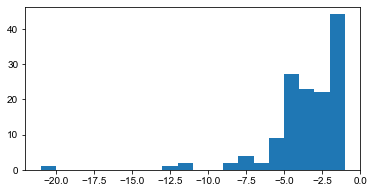

In [326]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(
    extubation_based_episode_duration - data.episode_duration[extubation_based_episode_duration.index],
    bins=20
);

In [327]:
data.loc[
    extubation_based_episode_duration.index, 
    "episode_duration"
] = extubation_based_episode_duration

### 4. Find overlapping episodes

In [328]:
idx = ~data.episode_duration.isna()

In [329]:
next_episode_idx = []
for i, r in data.loc[idx, :].iterrows():
    next_episode = data.loc[
        data.pt_study_id.eq(r.pt_study_id)
        & (data.icu_rank.gt(r.icu_rank) 
           | (data.icu_rank.eq(r.icu_rank) 
              & data.ICU_Day.gt(r.ICU_Day)))
        & data.episode_type.isin(["CAP", "HAP", "VAP"])
    ].head(1)
    if next_episode.size > 0:
        next_idx = next_episode.index[0]
        next_episode_idx.append((i, next_idx))
next_episode_idx = pd.DataFrame(
    next_episode_idx, 
    columns=["this_episode", "next_episode_index"]
)

In [330]:
delta = data.day_bucket_starts[next_episode_idx.next_episode_index].values - (
    data.day_bucket_starts[next_episode_idx.this_episode]
    + pd.to_timedelta(data.episode_duration[next_episode_idx.this_episode], unit="d")
)

In [331]:
overlapping = delta.loc[delta < pd.Timedelta(0)]

List of all overlapping episodes

data.loc[overlapping.index, ["pt_study_id", "icu_rank", "ICU_Day", "day_bucket_starts",
                             "episode_type", "etiology", "cured"]]

Here we're interested in VAPs only.

We will exclude Viral VAPs from analysis, because the Episode duration for such episodes is inaccurate and tricky. Also, majority of such episodes are first episodes in our dataset, these patients had previous episodes in other places and were transferred.

Check which viral VAPs are first episodes in our data

In [333]:
viral_vap_patients = data.loc[
    data.episode_type.eq("VAP") & data.etiology.eq("Viral")
].pt_study_id

In [334]:
patient_first_ep = data.loc[
    data.episode_type.isin(["CAP", "HAP", "VAP"])
].groupby("pt_study_id").head(1)

In [335]:
viral_vap_patients.index.isin(patient_first_ep.index)

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

viral_vap_patients[~viral_vap_patients.index.isin(patient_first_ep.index)]

### 5. Manual fixes after reviews by clinicians

In [337]:
data.loc[3605, ["cured", "cured_src", "episode_duration", "episode_duration_src"]] = ["Cured", "clin_impr_d14", 14, "clin_impr_d14"]
data.loc[
    3610, 
    ["cured", "cured_src", "episode_duration", "episode_duration_src", "etiology", "episode_type"]
] = np.nan

In [338]:
data.loc[12709, ["cured_src", "episode_duration", "episode_duration_src"]] = ["clin_impr_d14", 18, "day_antibiotics_stop"]
data.loc[
    12715, 
    ["cured", "cured_src", "episode_duration", "episode_duration_src", "etiology", "episode_type"]
] = np.nan

### 6. Recheck overlapping episodes

In [339]:
idx = ~data.episode_duration.isna()

In [340]:
next_episode_idx = []
for i, r in data.loc[idx, :].iterrows():
    next_episode = data.loc[
        data.pt_study_id.eq(r.pt_study_id)
        & (data.icu_rank.gt(r.icu_rank) 
           | (data.icu_rank.eq(r.icu_rank) 
              & data.ICU_Day.gt(r.ICU_Day)))
        & data.episode_type.isin(["CAP", "HAP", "VAP"])
    ].head(1)
    if next_episode.size > 0:
        next_idx = next_episode.index[0]
        next_episode_idx.append((i, next_idx))
next_episode_idx = pd.DataFrame(
    next_episode_idx, 
    columns=["this_episode", "next_episode_index"]
)

In [341]:
delta = data.day_bucket_starts[next_episode_idx.next_episode_index].values - (
    data.day_bucket_starts[next_episode_idx.this_episode]
    + pd.to_timedelta(data.episode_duration[next_episode_idx.this_episode], unit="d")
)

In [342]:
overlapping = delta.loc[delta < pd.Timedelta(0)]

List of all overlapping episodes

data.loc[overlapping.index, ["pt_study_id", "icu_rank", "ICU_Day", "day_bucket_starts",
                             "episode_type", "etiology", "cured"]]

In [344]:
print(f"Number of patients: {data.pt_study_id.nunique()}")
print(f"Number of ICU-days: {data.shape[0]}")

Number of patients: 601
Number of ICU-days: 13391


# 9. Clean columns and names

In [345]:
to_drop = """admission_datetime
discharge_datetime_x
discharge_datetime_y
icu_start_dt
icu_stop_dt
date_x
date_y
person_id
measurement_datetime
patient_ir_id_y
cohort_patient_id
patient_x
patient_y
First_intub_start
First_intub_stop
Second_intub_start
Second_intub_stop
Third_intub_start
Third_intub_stop
Fourth_intub_start
Fourth_intub_stop
Fifth_intub_start
Fifth_intub_stop
first_recorded_ecmo
last_recorded_ecmo
P_F_ratio_points
PF_dt
intub_flag
platelet_points
Platelet_dt
bilirubin_points
bilirubin_dt
htn_points
map_dts
length_of_time_on_med_in_min
gcs_points
gcs_dts
verbal_score_estimated_ind
renal_points
creatinine_dt
HD_or_CRRT_flag
patient_ir_id_x
Death_date
discharge_disposition_name
external_transfer_flag
admission_source_name
binary_outcome

""".strip().split("\n")
data.drop(to_drop, axis=1, inplace=True)

In [346]:
data = data.rename(columns={
    'on_ecmo': 'ECMO_flag',
    'on_intub': 'Intubation_flag',
    'HD_flag': 'Hemodialysis_flag',
    'mean_body_temp': 'Temperature', 
    'mean_heart_rate': 'Heart_rate',
    'mean_sys_blood_press': 'Systolic_blood_pressure', 
    'mean_dia_blood_press': 'Diastolic_blood_pressure',
    'map': 'Mean_arterial_pressure', 
    'mcg/kg/min': 'Norepinephrine_rate', 
    'mean_resp_rate': 'Respiratory_rate',
    'mean_oxigen_sat': 'Oxygen_saturation', 
    'urine_output': 'Urine_output', 
    'eye_opening_score': 'GCS_eye_opening',
    'best_motor_response_score': 'GCS_motor_response', 
    'best_verbal_response_score': 'GCS_verbal_response', 
    'rass_score': 'RASS_score', 
    'Peep': 'PEEP',
    'Static_Compliance': 'Lung_Compliance', 
    'n_peep_changes': 'PEEP_changes',
    'n_set_rate_changes': 'Respiratory_rate_changes', 
    'n_fio2_changes': 'FiO2_changes', 
    'mean_abg_ph': 'ABG_pH', 
    'mean_abg_paco2': 'ABG_PaCO2',
    'mean_abg_pao2':  'ABG_PaO2', 
    'PF_ratio': 'PaO2FIO2_ratio', 
    'WBC count': 'WBC_count', 
    'Platelet': 'Platelets',  
    'creatinine': 'Creatinine',
    'bilirubin': 'Bilirubin',
    'D-dimer': 'D_dimer',
    'Lactic Acid': 'Lactic_acid',
    
    'SOFA2':'SOFA_score', #adding this row as recalculated it above 
    
    'pt_study_id': 'patient',
    'icu_rank': 'stay',
    'ICU_Day': 'day',
    'death_date':'Death_date',
    
    'num_aliquot_cryopres': 'Cryopreserved_samples',
    'ID': 'Single_cell_library',
    'Chemistry': 'Single_cell_chemistry',
    'etiology': 'Episode_etiology',
    'cured': 'Episode_is_cured',
    'cured_src': 'Episode_is_cured_source',
    'episode_duration': 'Episode_duration',
    'episode_duration_src': 'Episode_duration_source',
    'episode_type': 'Episode_category',
    'cause_failure': 'Global_cause_failure'

})

In [347]:
to_drop = """
ir_id_x
SOFA
ir_id_y
case_number
lung_transplant
meta_orignl_load_dts
meta_load_exectn_guid
administration_date
hypotension_points
htn_med_name
dosage
mean_abg_bicarb
""".strip().split("\n")
data.drop(to_drop, axis=1, inplace=True)

In [348]:
data = data.rename(columns={
    'stay': 'ICU_stay',
    'day': 'ICU_day',
})

In [349]:
parameters_order = [
    # Patient-level things

    'Patient_id', 'patient', 'External_transfer_flag',
       'Admission_source_name', 'Discharge_disposition', 'Binary_outcome',
       'Death_date', 'Global_cause_failure', 
            'Patient_category', 'COVID_status', #add back in later
    
    'Age', 'Ethnicity', 'Gender', 'Race', 'Smoking_status',
       'BMI', 'Admit_APS_score', 'Admit_SOFA_score',  'Cumulative_ICU_days', 'Number_of_ICU_stays',
       'Tracheostomy_flag', 'Cumulative_intubation_days',
    
    # Stay-level things
    'icu_stay_start_datetime', 'icu_stay_stop_datetime', 'ICU_stay',
    # Day-level things
    'day_bucket_starts', 'ICU_day', 'SOFA_score', #CAG 7-21 changed from SOFA to SOFA_score
    # Day-level parameters
    'ECMO_flag', 'Intubation_flag',
    'Hemodialysis_flag', 'CRRT_flag', 'Temperature', 'Heart_rate',
    'Systolic_blood_pressure', 'Diastolic_blood_pressure',
    'Mean_arterial_pressure', 'Norepinephrine_rate', 
    'Norepinephrine_flag', #CAG 7-21 added this 
    'Respiratory_rate',
    'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
    'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
    'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
    'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
    'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
    'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
    'Bilirubin', 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid',
    'Procalcitonin',
    
    # BAL things
    'bal_barcode', 'bar_barcode', 'Cryopreserved_samples', 'Single_cell_library', 
    'Single_cell_chemistry',
    # Episode things
    'Episode_category', 'Episode_etiology', 'Episode_is_cured', 
    'Episode_is_cured_source', 'Episode_duration', 'Episode_duration_source', 

]
data = data[parameters_order].copy()

In [350]:
data.shape

(13391, 83)

In [351]:
data.External_transfer_flag = data.External_transfer_flag.astype(int)

In [352]:
data.ECMO_flag = data.ECMO_flag.astype(int)
data.Intubation_flag = data.Intubation_flag.astype(int)

In [353]:
data.ICU_stay = data.ICU_stay.astype(int)
data.ICU_day = data.ICU_day.astype(int)
data.patient = data.patient.astype(int)

In [354]:
data.Age = data.Age.astype(int)
data.Patient_id = data.Patient_id.astype(int)
data.Binary_outcome = data.Binary_outcome.astype(int)
data.Cumulative_ICU_days = data.Cumulative_ICU_days.astype(int)
data.Number_of_ICU_stays = data.Number_of_ICU_stays.astype(int)
data.Tracheostomy_flag = data.Tracheostomy_flag.astype(int)
data.Cumulative_intubation_days = data.Cumulative_intubation_days.astype(int)
data.SOFA_score = data.SOFA_score.astype(int)
data.Norepinephrine_flag = data.Norepinephrine_flag.astype(int)

Set BAL flags

In [355]:
data.insert(data.columns.get_loc("bal_barcode"), "has_bal", ~data.bal_barcode.isna())

In [356]:
data.insert(
    data.columns.get_loc("Single_cell_library"), "bal_sequenced", ~data.Single_cell_library.isna()
)

# 10. Fill dialysis `NA` with `0` 

In [357]:
data.Hemodialysis_flag.value_counts(dropna=False)


NaN    12599
1.0      792
Name: Hemodialysis_flag, dtype: int64

In [358]:
data.Hemodialysis_flag.fillna(0, inplace=True)

In [359]:
data.Hemodialysis_flag = data.Hemodialysis_flag.astype(int)

In [360]:
data.CRRT_flag.value_counts(dropna=False)

NaN    11451
1.0     1940
Name: CRRT_flag, dtype: int64

In [361]:
data.CRRT_flag.fillna(0, inplace=True)

In [362]:
data.CRRT_flag.value_counts()

0.0    11451
1.0     1940
Name: CRRT_flag, dtype: int64

In [363]:
data.CRRT_flag = data.CRRT_flag.astype(int)

# 11. Range curation

In [364]:
columns_to_curate = [
    'Mean_arterial_pressure', 'Norepinephrine_rate', 
    'Urine_output', 'GCS_eye_opening', 'GCS_motor_response',
    'GCS_verbal_response', 'RASS_score', 'PaO2FIO2_ratio',
    'Platelets', 'Creatinine', 'Bilirubin'
]

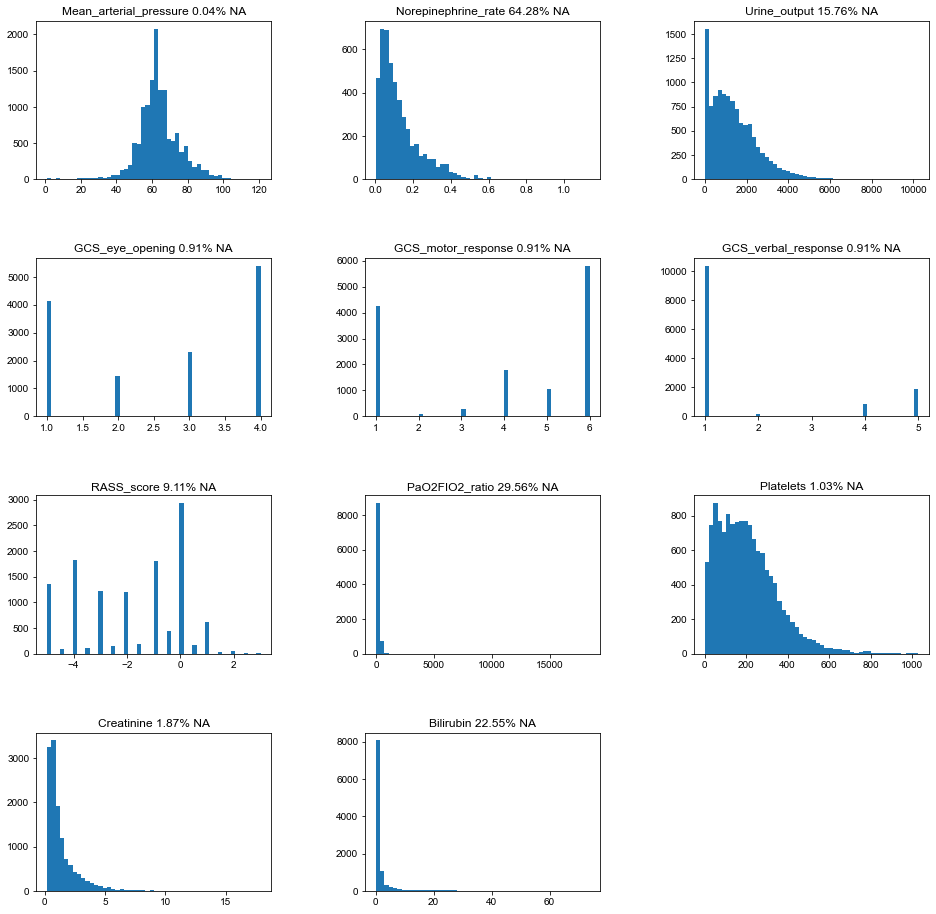

In [365]:
columns = np.array(columns_to_curate)
cols = np.pad(columns, (0, 12 - columns.size), constant_values=np.nan).reshape(4, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 16), 
    gridspec_kw={"wspace": 0.4, "hspace": 0.5}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        if isinstance(column, str) and column in data:
            ax.hist(
                data[column], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {data[column].isna().sum() * 100 / data.shape[0]:.2f}% NA")
        else:
            ax.remove()

In [366]:
allowed_range = {
    "Mean_arterial_pressure": (20, 130),
    "Urine_output": (0, 7000),
    "PaO2FIO2_ratio": (0, 800),
    "Platelets": (0, 800),
    "Creatinine": (0, 8),
    "Bilirubin": (0, 15),
}

In [367]:
for column in data.columns:
    for c, ranges in allowed_range.items():
        if column == c:
            break
        if c in column:
            break
    if c != column and c not in column:
        continue
    n_val = ((data[column] < ranges[0]) | (data[column] > ranges[1])).sum()
    data.loc[(data[column] < ranges[0]) | (data[column] > ranges[1]), column] = np.nan
    print(f"# of values outside of range {ranges} for {column} = {n_val}")


# of values outside of range (20, 130) for Mean_arterial_pressure = 79
# of values outside of range (0, 7000) for Urine_output = 14
# of values outside of range (0, 800) for PaO2FIO2_ratio = 25
# of values outside of range (0, 800) for Platelets = 24
# of values outside of range (0, 8) for Creatinine = 34
# of values outside of range (0, 15) for Bilirubin = 307


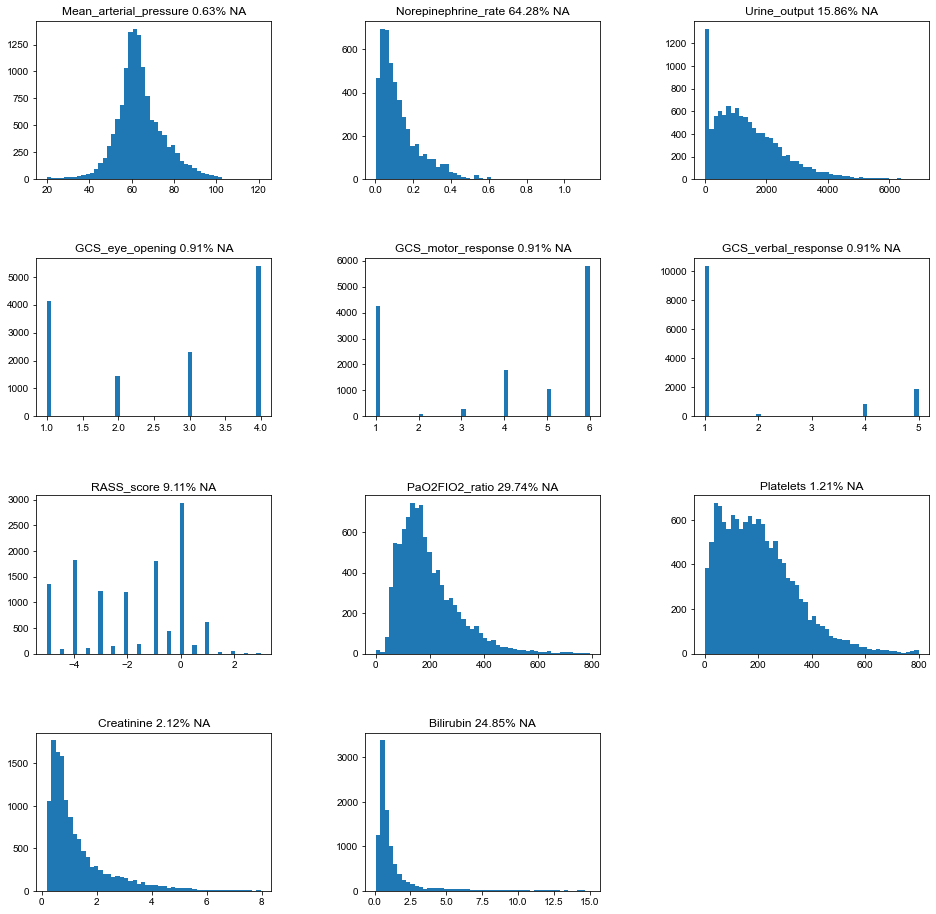

In [368]:
columns = np.array(columns_to_curate)
cols = np.pad(columns, (0, 12 - columns.size), constant_values=np.nan).reshape(4, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=(16, 16), 
    gridspec_kw={"wspace": 0.4, "hspace": 0.5}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        ax = axes[row, col]
        if isinstance(column, str) and column in data:
            ax.hist(
                data[column], 
                bins=50,
#                 log=True
            )
            ax.set_title(column + f" {data[column].isna().sum() * 100 / data.shape[0]:.2f}% NA")
        else:
            ax.remove()

# 12. Set Global cause failure to all patient-days

Check noone has 2 global causes

In [369]:
data.groupby("patient").Global_cause_failure.nunique().gt(1).sum()

0

In [370]:
global_cause = data.loc[
    :, 
    ["patient", "Global_cause_failure"]
].dropna().drop_duplicates().set_index("patient")

In [371]:
global_cause.Global_cause_failure = global_cause.Global_cause_failure.str.replace(
    "Inflam", "Persistent inflammation only", regex=False
).str.replace(
    "Super", "Superinfection pneumonia", regex=False
).str.replace(
    "Abx", "Antibiotics for other indication", regex=False
)

In [372]:
idx = data.patient.isin(global_cause.index)
data.loc[
    idx, 
    "Global_cause_failure"
] = global_cause.Global_cause_failure[data.patient[idx]].values

# 13. Save

In [373]:
data = data.set_index(
    data.patient.astype(str) + "/" + data.ICU_stay.astype(str) + "/" + data.ICU_day.astype(str)
)

In [374]:
data.sort_values(["patient", "ICU_stay", "ICU_day"], inplace=True)

In [375]:
export.full_frame(
    user=user,
    p=f'{outfolder}/01_assembled_data.csv.gz',
    df=data,
    index='true'
) 

Necessary step to check, because of pandas rounding when saving/loading

In [384]:
p = os.path.join(
    inout.get_path_from_settings('materials_path'),
    'general/01_assembling_data/01_assembled_data.csv.gz'
)

In [385]:
new = pd.read_csv(p, index_col=0)

In [386]:
new.reset_index(drop=True, inplace=True)

# 14. Check against previous version dataset 

p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'edw/from_2022-03-23-v5-data-clean/11data-v2-admit_sofa_aps7-11-22.csv.gz'
)

current = pd.read_csv(p, index_col=0)

current = current.rename(columns={
    'stay': 'ICU_stay',
    'day': 'ICU_day',
})

current = current.fillna(-999)
new = new.fillna(-999)

for k, v in current.eq(new).sum().iteritems():
    if k not in new:
        print(f"Column {k} absent")
        continue
    if v < new.shape[0]:
        if pd.api.types.is_numeric_dtype(current[k]):
            diff = new[k] - current[k]
            print(f"{k}: {new.shape[0] - v} diff, mean={diff.mean()}")
        else:
            diff = new[k].ne(current[k])
            print(f"{k}: {new.shape[0] - v} diff")